# Top 5 Zipcodes to Invest In

## 1. Overview 
*fill in later*

##  2. Buisness Problem

A real estate investment firm centered in Philadelphia reached out to a consultant to help them figure out **"What are the top 5 best zip codes for us to invest in?"**.  The goal of the analysis in this notebook is to answer the stakeholder's question by reccomending the top 5 zipcodes to invest in *and* explain the logic behind those reccomendations.


----


## 3. Dataset
The dataset was origionally extracted from [Zillow Research](https://www.zillow.com/research/data/) and was taken from this [repo](https://github.com/learn-co-curriculum/dsc-phase-4-choosing-a-dataset/tree/main/time-series). 

Zillow is an website that advertises properties for rent or sale all over the USA. Due to it's easy accessability and expansive data collection throughout the USA, we chose to use this dataset to evaluate our data. In the raw data, we had **14,723** rows and **272** columns, but after changing the shape of our data so as to hace a seperate row for each unique zipcode and date we had **3,744,704** rows and **7** columns. The dataset covers from April 1996 through April 2018, and includes the median sales information for every month between those years. 

## Initial Look at the Data

### Imports 

In [41]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [42]:
# initial look at the raw data and importing the second column (with the zipcodes) as an object, not an integer
data = pd.read_csv("zillow_data.csv", dtype={'RegionName': object})
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(48), object(5)
memory usage: 30.6+ MB


## Data Preprocessing

We are going to get rid of the columns `RegionID` and `SizeRank` as they seem irrelevant to our current line of questioning. (We don't care about the size or region of the zipcodes we reccomend.) We are then going to reformat our data so we can look for and deal with any NaN's we may come across. 

In [44]:
data.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

In [45]:
data.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [46]:
# pulling out Philly data specifically 
phil_data = data.loc[data["Metro"]== "Philadelphia"]
phil_data

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,167100,168100,169300,170600,171900,172700,173200,174000,175200,175800
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,79800,80900,82200,83000,83800,84300,84200,84900,86700,88200
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,305400,307700,309200,309300,308800,308900,310100,311600,314000,315900
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,250000,251600,252600,253800,255400,256400,257500,257600,255600,253400
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173100,173200,172600,173400,178700,185200,189000,189400,184700,179000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,08026,Gibbsboro,NJ,Philadelphia,Camden,100500.0,100800.0,101100.0,101300.0,101500.0,...,174200,172800,173400,174300,174500,171100,166000,165200,171300,176600
14189,08067,Oldmans,NJ,Philadelphia,Salem,81300.0,81600.0,81900.0,82100.0,82400.0,...,145400,146400,147000,147200,147800,148400,147900,150500,158500,165900
14239,19453,Upper Providence,PA,Philadelphia,Montgomery,110100.0,109900.0,109700.0,109500.0,109300.0,...,210900,212100,212500,213700,215300,217500,220200,222400,223800,224800
14496,18915,Hatfield,PA,Philadelphia,Montgomery,165300.0,165300.0,165400.0,165400.0,165400.0,...,316500,318300,320200,321600,322000,322000,322700,323900,325700,327000


In [47]:
#checking for null values
phil_data[pd.isna(phil_data).any(axis=1)]

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [53]:
phil_data['t_growth'] = (phil_data['2018-04'] - phil_data['1996-04']) / phil_data['1996-04']
phil_data['growth1'] = (phil_data['2007-09'] - phil_data['1996-04']) / phil_data['1996-04']
phil_data['growth2'] = (phil_data['2018-04'] - phil_data['2011-03']) / phil_data['2011-03']
# re-check the info in a bit more manageable slice
phil_shortform = phil_data.loc[:,['RegionName','City','State','Metro','t_growth','growth1','growth2']]
phil_shortform.head()

<ipython-input-53-f206e726a927>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phil_data['t_growth'] = (phil_data['2018-04'] - phil_data['1996-04']) / phil_data['1996-04']
<ipython-input-53-f206e726a927>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phil_data['growth1'] = (phil_data['2007-09'] - phil_data['1996-04']) / phil_data['1996-04']
<ipython-input-53-f206e726a927>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,RegionName,City,State,Metro,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,0.960570,1.111720,0.198928


In [54]:
# re-check the info in a bit more manageable slice
phil_shortform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 194 to 14537
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  281 non-null    object 
 1   City        281 non-null    object 
 2   State       281 non-null    object 
 3   Metro       281 non-null    object 
 4   t_growth    281 non-null    float64
 5   growth1     281 non-null    float64
 6   growth2     281 non-null    float64
dtypes: float64(3), object(4)
memory usage: 17.6+ KB


In [56]:
phil_shortform.describe()

,t_growth,growth1,growth2
count,281.000000,281.000000,281.000000
mean,1.086182,1.181123,0.114567
std,0.755744,0.430239,0.132367
min,0.237132,0.713235,-0.147526
25%,0.774878,1.004141,0.040498
50%,0.960227,1.108796,0.114919
75%,1.148588,1.209726,0.165386
max,7.046012,4.311475,1.059172


In [58]:
# find the top 5 zipcodes in Philadelphia who grew the most after the 2008 crash
phil_shortform.sort_values('growth2',ascending=False).head(5)

,RegionName,City,State,Metro,t_growth,growth1,growth2
666,19145,Philadelphia,PA,Philadelphia,4.155556,1.975309,1.059172
3615,19125,Philadelphia,PA,Philadelphia,7.046012,3.288344,0.956003
518,19148,Philadelphia,PA,Philadelphia,4.111922,2.481752,0.586858
940,19103,Philadelphia,PA,Philadelphia,3.784584,2.756508,0.542373
784,19147,Philadelphia,PA,Philadelphia,5.941176,4.105169,0.541568


In [59]:
# find the top 5 zipcodes who had the worst reovery after the crash
phil_shortform.sort_values('growth2',ascending=False).tail(5)

,RegionName,City,State,Metro,t_growth,growth1,growth2
678,08021,Lindenwold,NJ,Philadelphia,0.471698,1.100236,-0.102804
12781,08063,National Park,NJ,Philadelphia,0.476942,1.134709,-0.107117
9024,19079,Sharon Hill,PA,Philadelphia,0.425076,0.738532,-0.136237
8037,08079,Salem,NJ,Philadelphia,0.436765,1.039706,-0.139965
7613,08030,Gloucester City,NJ,Philadelphia,0.402458,1.227343,-0.147526


Text(0, 0.5, 'Growth percentage')

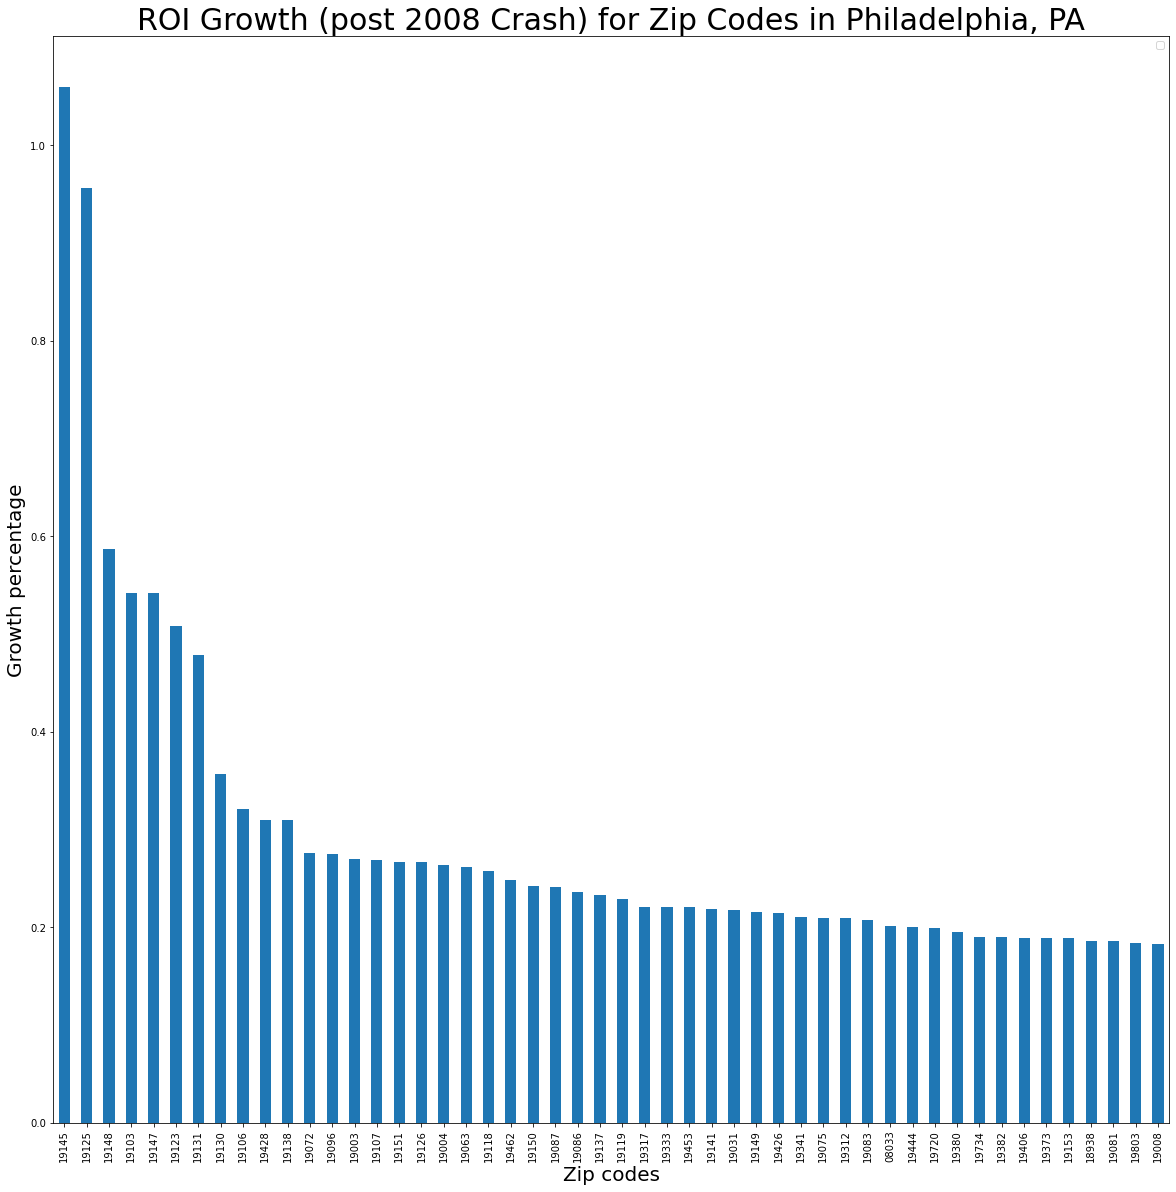

In [61]:
phil_shortform[['RegionName','growth2']].sort_values(by='growth2',ascending=False).head(50).plot.bar(x='RegionName', y='growth2',figsize=(20,20))
plt.title('ROI Growth (post 2008 Crash) for Zip Codes in Philadelphia, PA', fontsize=30)
plt.legend('')
plt.xlabel('Zip codes',fontsize=20)
plt.ylabel('Growth percentage',fontsize=20)


In [55]:
#pulling out the date columns so we can more easily change the format later on
#dates = data.loc[:, ~data.columns.isin(['RegionName','City', 'State', 'Metro', 'CountyName'])]
#dates.head()

In [7]:
# adjusting the column names so we can use pd.melt later
#column_names_to_change = {}

#for column in dates.columns:
    #column_names_to_change[column] = f'{column}-01'
    
#data.rename(columns=column_names_to_change, inplace=True)

#data.head()

,RegionName,City,State,Metro,CountyName,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [8]:
#melting the data so we have it in the long version, instead of wide
#melted = pd.melt(data, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#makeing our new column `time` a datetime variable 
#melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
# getting rid of rows that are missing `value` values
#melted_nonan = melted.dropna(subset=['value'])


In [9]:
#looking at our pretty long version of our data!
#melted_nonan.head()

,RegionName,City,State,Metro,CountyName,time,value
0,60657,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [10]:
# wow - so many rows!
#melted_nonan.shape

(3744704, 7)

In [23]:
# re-check the info now that our DataFrame is a bit more manageable
phil_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 194 to 14537
Columns: 273 entries, RegionName to growth2
dtypes: float64(222), int64(47), object(4)
memory usage: 601.5+ KB


Looks like our zipcodes (`RegionName`) are listed as integers, not strings. Lets change that. 

In [12]:
#melted_nonan['RegionName'] = melted_nonan['RegionName'].astype('object')

<ipython-input-12-853b908fd5a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_nonan['RegionName'] = melted_nonan['RegionName'].astype('object')


In [13]:
melted_nonan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  object        
 1   City        object        
 2   State       object        
 3   Metro       object        
 4   CountyName  object        
 5   time        datetime64[ns]
 6   value       float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 228.6+ MB


In [14]:
melted_nonan.describe()

,value
count,3.744704e+06
mean,2.076064e+05
std,2.400207e+05
min,1.130000e+04
25%,9.790000e+04
50%,1.476000e+05
75%,2.372000e+05
max,1.931490e+07


In [15]:
# checking for missing values
melted_nonan.isnull().sum()

RegionName         0
City               0
State              0
Metro         236023
CountyName         0
time               0
value              0
dtype: int64

In [16]:
# looking into the missing values - code from https://stackoverflow.com/questions/43424199/display-rows-with-one-or-more-nan-values-in-pandas-dataframe
melted_nonan[melted_nonan.isnull().any(axis=1)]

,RegionName,City,State,Metro,CountyName,time,value
151,27410,Greensboro,NC,NaN,Guilford,1996-04-01,137100.0
167,27406,Greensboro,NC,NaN,Guilford,1996-04-01,80900.0
491,27265,High Point,NC,NaN,Guilford,1996-04-01,108000.0
526,27407,Greensboro,NC,NaN,Guilford,1996-04-01,93900.0
695,27405,Greensboro,NC,NaN,Guilford,1996-04-01,74100.0
...,...,...,...,...,...,...,...
3901556,28775,Scaly Mountain,NC,NaN,Macon,2018-04-01,216700.0
3901566,97149,Neskowin,OR,NaN,Tillamook,2018-04-01,413400.0
3901582,3812,Bartlett,NH,NaN,Carroll,2018-04-01,228000.0
3901589,12720,Bethel,NY,NaN,Sullivan,2018-04-01,117700.0


Just from looking up some of the zipcodes from the rows that are missing values (see above), it seems that these locations aren't close to a large "metro" area - as such, lets just replace these NaN's with `Missing` , just in case we want to look into them futher later on. 

In [17]:
# replacing Nan's with 
melted_nonan.Metro = melted_nonan.Metro.fillna('Missing')

/Users/rachelsanderlin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
# checkinf for NaN's
melted_nonan.isnull().sum()

RegionName    0
City          0
State         0
Metro         0
CountyName    0
time          0
value         0
dtype: int64

Now that we've sorted out our missing values, lets check the number of unique variables in all of our columns. 

In [19]:
melted_nonan.nunique()

RegionName    14723
City           7554
State            51
Metro           702
CountyName     1212
time            265
value         24372
dtype: int64

We see here that we have 14,723 unique zipcodes, 7,554 cities, 51 states (we'll have to investigate how we got to 51 out of 50), 702 metro areas (including the `missing` label we made) with 1,212 differnt county names. 

In [20]:
counts = melted_nonan['RegionName'].value_counts()
counts

99901    265
30720    265
30750    265
30742    265
30741    265
        ... 
4009      46
45872     46
73173     46
62870     46
32435     46
Name: RegionName, Length: 14723, dtype: int64

<AxesSubplot:>

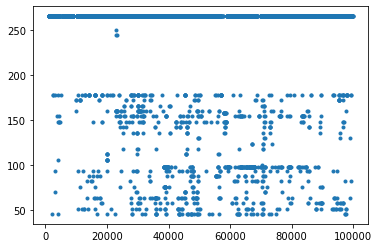

In [40]:
melted_nonan.RegionName.value_counts().plot(style='.')

In [45]:
melted_nonan.City.value_counts().head(15)

New York        29058
Los Angeles     24761
Houston         22934
San Antonio     12720
Washington      11637
Chicago         10658
Austin          10600
Springfield     10600
Philadelphia     9903
Las Vegas        9881
Phoenix          9634
Kansas City      9598
Dallas           9062
Columbus         8952
Portland         8791
Name: City, dtype: int64

In [46]:
#state includes DC - hence the 51 states
melted_nonan.State.value_counts()

CA    318744
NY    265015
TX    255096
PA    215451
FL    205265
OH    146313
IL    140587
NJ    133030
MI    124765
MA    110112
NC    110024
IN    107300
TN    106349
VA    103160
MN     94384
WA     89672
WI     87215
GA     85005
MD     83531
MO     76361
CO     65697
AZ     58775
OR     57350
OK     56938
SC     52436
NH     52171
KS     51500
AL     43896
LA     43523
IA     40640
KY     34234
CT     32860
UT     31230
ID     27363
AR     26721
MS     25837
NV     24826
ME     21659
NE     20172
WV     17730
MT     15638
RI     15635
HI     15011
NM     14553
DE      8630
AK      7420
WY      7092
DC      4770
ND      4526
SD      4252
VT      4240
Name: State, dtype: int64

ValueError: Date ordinal -964693.9500000001 converts to -672-10-04T01:12:00.000000 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.